# Modelling of France Accidents

**Cohort:** mar23_accidents

**Author:** Tobias Schulze

**Date:** 30 Oktober 2023



## Loading of required libraries

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import xgboost as xgb
import re
import pickle
import warnings
import time
import shap
from hyperopt import STATUS_OK, Trials, fmin, hp, tpe
from datetime import datetime, timedelta
from sklearn.preprocessing import LabelEncoder, MinMaxScaler, StandardScaler
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from sklearn.model_selection import train_test_split
from sklearn.feature_selection import SelectFromModel
from matplotlib import pyplot

## Controlling notebook
For rerun of the notebook, only the stored parameters / models are used.

In [2]:
# Rerun (True) or get stored parameters (False)
cv_rerun = False

## Importing the data

In [3]:
df = pd.read_csv('./data/231030_clean_table_for_analysis.csv', low_memory = False, index_col = 0)

## Data description
### Data
Show first five rows of the dataframe.

In [4]:
df.head()

,place,catu,grav,sexe,an_nais,trajet,locp,an,mois,jour,...,manv,date,is_holiday,holiday,datetime,actp,num_veh,etatp,day_of_week,hour_of_day
Num_Acc,,,,,,,,,,,,,,,,,,,,,
201900000001,2.0,2,4,2,2002,0.0,-1.0,2019,11,30,...,23.0,2019-11-30,False,NaN,2019-11-30 01:30:00,0,14,0,5,1
201900000001,1.0,1,4,2,1993,5.0,-1.0,2019,11,30,...,23.0,2019-11-30,False,NaN,2019-11-30 01:30:00,0,14,0,5,1
201900000001,1.0,1,1,1,1959,0.0,-1.0,2019,11,30,...,11.0,2019-11-30,False,NaN,2019-11-30 01:30:00,0,0,0,5,1
201900000002,1.0,1,4,2,1994,0.0,-1.0,2019,11,30,...,0.0,2019-11-30,False,NaN,2019-11-30 02:50:00,0,0,0,5,2
201900000003,1.0,1,1,1,1996,0.0,-1.0,2019,11,28,...,2.0,2019-11-28,False,NaN,2019-11-28 15:15:00,1,0,0,3,15


### Data types
Show the columns and their data types.

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 2421684 entries, 201900000001 to 201800055766
Data columns (total 42 columns):
 #   Column       Dtype  
---  ------       -----  
 0   place        float64
 1   catu         int64  
 2   grav         int64  
 3   sexe         int64  
 4   an_nais      int64  
 5   trajet       float64
 6   locp         float64
 7   an           int64  
 8   mois         int64  
 9   jour         int64  
 10  hrmn         object 
 11  lum          int64  
 12  agg          int64  
 13  int          int64  
 14  atm          float64
 15  col          float64
 16  dep          int64  
 17  catr         float64
 18  circ         float64
 19  nbv          float64
 20  vosp         float64
 21  prof         float64
 22  plan         float64
 23  surf         float64
 24  infra        float64
 25  situ         float64
 26  senc         float64
 27  catv         int64  
 28  occutc       float64
 29  obs          float64
 30  obsm         float64
 31  choc         

### Missing data
Check the data for missing values.

In [6]:
df.isna().sum()

place                0
catu                 0
grav                 0
sexe                 0
an_nais              0
trajet               0
locp                 0
an                   0
mois                 0
jour                 0
hrmn                 0
lum                  0
agg                  0
int                  0
atm                  0
col                  0
dep                  0
catr                 0
circ                 0
nbv                  0
vosp                 0
prof                 0
plan                 0
surf                 0
infra                0
situ                 0
senc                 0
catv                 0
occutc               0
obs                  0
obsm                 0
choc                 0
manv                 0
date                 0
is_holiday           0
holiday        2367768
datetime             0
actp                 0
num_veh              0
etatp                0
day_of_week          0
hour_of_day          0
dtype: int64

This data has no missing values, accept the `holiday` variable which contains the name of the holiday or NaN.

### Drop variables
The dataset contains still some variables that represent information represented by other variables or are a finer granulation. The latter might be added later, if the primary variable is relevant.

- `holiday`: classifies the holiday, but will be used only, if `is_holiday` is relevant
- `datetime`: was required to create other datetime variables
- `hrmn`: was required to create time related variables

In [7]:
columns_drop = ['holiday', 'hrmn', 'datetime']

df.drop(columns = columns_drop, inplace = True)

In [8]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 2421684 entries, 201900000001 to 201800055766
Data columns (total 39 columns):
 #   Column       Dtype  
---  ------       -----  
 0   place        float64
 1   catu         int64  
 2   grav         int64  
 3   sexe         int64  
 4   an_nais      int64  
 5   trajet       float64
 6   locp         float64
 7   an           int64  
 8   mois         int64  
 9   jour         int64  
 10  lum          int64  
 11  agg          int64  
 12  int          int64  
 13  atm          float64
 14  col          float64
 15  dep          int64  
 16  catr         float64
 17  circ         float64
 18  nbv          float64
 19  vosp         float64
 20  prof         float64
 21  plan         float64
 22  surf         float64
 23  infra        float64
 24  situ         float64
 25  senc         float64
 26  catv         int64  
 27  occutc       float64
 28  obs          float64
 29  obsm         float64
 30  choc         float64
 31  manv         

## Data preparation
### Encode or drop date variables
The `XGboost` algorithm cannot handle `datetime` encoded data, and thus conversion to `integer` is a good option.

The integer will show the integer of the date relative to the start of the current time epoch.


In [9]:
df = df.assign(date = pd.to_datetime(df['date']))
df['date'] = df.apply(lambda x: int(x['date'].timestamp()), axis = 1)

In [10]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 2421684 entries, 201900000001 to 201800055766
Data columns (total 39 columns):
 #   Column       Dtype  
---  ------       -----  
 0   place        float64
 1   catu         int64  
 2   grav         int64  
 3   sexe         int64  
 4   an_nais      int64  
 5   trajet       float64
 6   locp         float64
 7   an           int64  
 8   mois         int64  
 9   jour         int64  
 10  lum          int64  
 11  agg          int64  
 12  int          int64  
 13  atm          float64
 14  col          float64
 15  dep          int64  
 16  catr         float64
 17  circ         float64
 18  nbv          float64
 19  vosp         float64
 20  prof         float64
 21  plan         float64
 22  surf         float64
 23  infra        float64
 24  situ         float64
 25  senc         float64
 26  catv         int64  
 27  occutc       float64
 28  obs          float64
 29  obsm         float64
 30  choc         float64
 31  manv         

The correlation matrix shows some intervariable correlations, but no real importance of variables to predict the target `fatal`. 

#### Aggregation and encoding of the target variable
In the previous notebook, we used the `grav` variable as is without any further processing. The modelling result was not satisfying. Therefore, it was decided to aggregate the four classes into two classes "severe" and "non-severe" encoded in `[1,0]`.

In [11]:
df.grav.unique()

array([4, 1, 2, 3])

In [12]:
# Encoding
# grav encodes in 1=unscathed, 2=light injured, 3=hospitalized, 4=killed.
# Thus [1,2] = 0, [3,4] = 1

df['severe'] = np.where(df['grav'].isin([1, 2]), 0, 1)

In [13]:
# Check the data
df.severe.unique()

array([1, 0])

The following visualisation shows the balance between the two classes. The dataset is much more balanced now compared to the four classes `grav`.

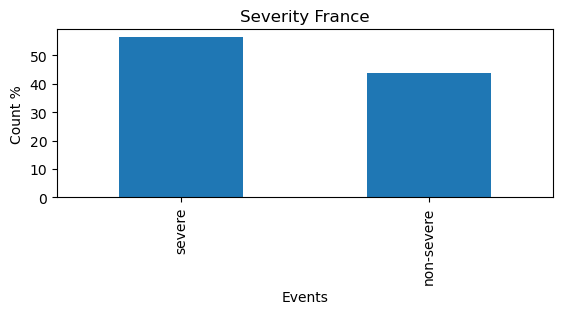

In [14]:
# test if the 
import matplotlib.pyplot as plt
# exploring severe cases in % 
event_counts = df['severe'].value_counts()
event_percentages = (event_counts / event_counts.sum()) * 100
plt.subplot(2,1,1)
event_percentages.plot.bar()
labels = ['severe','non-severe']
# Add labels and title to the plot
plt.xticks(range(len(event_counts)), labels)
plt.xlabel('Events')
plt.ylabel('Count %')
plt.title('Severity France')
# Display the plot
plt.show()

## Data analysis
### Correlation matrix
To get a first glimpse on the possible contrains in the data, a correlation matrix is plotted.

In [15]:
# Sort columns
columns = df.columns.sort_values()
df = df[columns]

In [16]:
# Scale the data
scaler = MinMaxScaler()
df_numeric_scaled = pd.DataFrame(scaler.fit_transform(df), columns=df.columns)

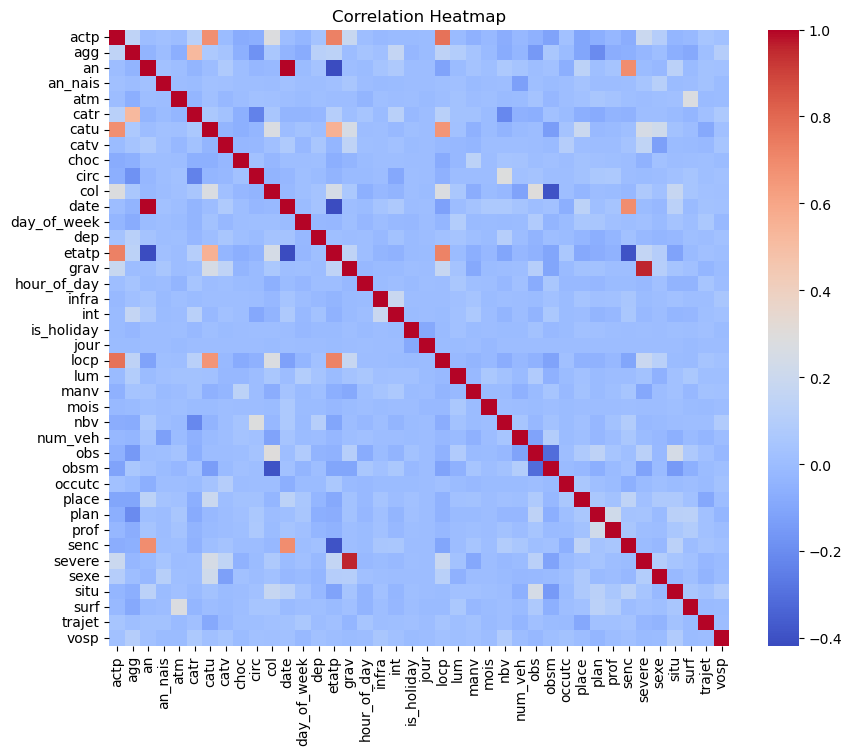

In [17]:
# Create a correlation matrix
correlation_matrix = df_numeric_scaled.corr()
plt.figure(figsize=(10, 8))
# Generate the heatmap
sns.heatmap(correlation_matrix, annot=False, cmap='coolwarm')

# Add a title
plt.title('Correlation Heatmap')

# Display the plot
plt.show();

### Preparation of the training and test datasets
#### Split data
The dataset is split by year slides. We decided to drop the Covid-19 years 2020-21. The years 2005 to 2017 are selected for the train dataset and the years 2018 and 2019 for the test dataset. Furthermore, the `grav` variable is dropped because it is encoded in `severe`.


In [18]:
df.drop('grav', axis = 1, inplace = True)

In [19]:
# split the dataset to train and test data
X_train = df.loc[df['an'] < 2018]
X_train = X_train.drop('severe', axis = 1)

X_test = df[(df['an'] >= 2018) & (df['an'] < 2020)]
X_test = X_test.drop('severe', axis = 1)

y_train = df['severe'].loc[df['an'] < 2018]
y_test = df['severe'][(df['an'] >= 2018) & (df['an'] < 2020)]


#### Data scaling
Decision trees are not sensitive to different scales and thus scaling is not required.

### Modelling the data using a XGBoost Classification Model with Tree-based Parzen Estimators optimisation
The Tree-based Parzen Estimator (TPE) [1] optimisation combines a Bayesian Sequential Model Based Optimisation (SMBO) and a random search on the hyperparemeter grid[2]. While the random search is a static approach, the SMBO optimises the model using prior runs to determine future points of exploration.

The package `hyperopt` [4] is used for optimisation. The hyperparameter optimisation code is written based on ideas in [5].

#### The tuning space
`hyperopt` uses a specific format of parameters expressions [7]. Hints on the parameter ranges are given in [1,5,7].

The `booster` in this first model is `gbtree`. The evaluation metric is `logloss` or `auc`[8].

Another classification method is Dropout with Multiple Additive Regression Trees (`dart`)[9], which is not used here.

The metric used is `mlogloss` (as a special case of `logloss`). The reason is that `logloss` is an absolute measure of the quality of the classification, while `auc` is a simple ranking function [10]. `logloss` is discussed as better performing with imbalanced datasets [11].


In [20]:
# Create the tuning space
booster = 'gbtree'
eval_metric = 'logloss'

tuning_space={
    'eta': hp.uniform('eta', 0, 1),
    'max_depth': hp.quniform('max_depth', 3, 10, 1),
    'gamma': hp.uniform ('gamma', 0, 10),
    'reg_alpha' : hp.uniform('reg_alpha', 0, 100),
    'reg_lambda' : hp.uniform('reg_lambda', 0, 10),
    'colsample_bytree' : hp.uniform('colsample_bytree', 0, 1),
    'colsample_bylevel' : hp.uniform('colsample_bylevel', 0, 1),
    'colsample_bynode' : hp.uniform('colsample_bynode', 0, 1),
    'min_child_weight' : hp.quniform('min_child_weight', 0, 10, 1),
    'n_estimators': hp.quniform('n_estimators', 10, 1000, 1), # default is 100, so we try to check in the one magnitude space
    'seed': 123,
    'early_stopping_rounds': 10, # stop tuning early to avoid overfitting
    'objective': 'binary:logistic',
    'subsample': hp.uniform('subsample', 0, 1)
    }

tuning_space.update({'scale_pos_weight': hp.uniform('scale_pos_weight', 0, 2)}) # helps in auc
tuning_space.update({'max_delta_step': hp.uniform('max_delta_step', 0, 2)}) # helps in auc
tuning_space.update({'eval_metric': eval_metric})
tuning_space.update({'booster': booster})


#### The tuning function
The following function integrates all steps required for the hyperoptimization tuning. The results are stored in the model and the tuning score is printed per step.

In [21]:
# Function for the classification
def hp_xgbclass(space, X_train = X_train, y_train = y_train, X_test = X_test, y_test = y_test):
    """ Function for Bayesian hyperparameter optimisation of XGboost classification model.
    Accepts a parameter `space` and the training and testing data set.
        :param tuning_space: a catalog containing the parameters used for hyperparameter tuning, ranges given in hp objects
        :param X_train: accepts the train data
        :param X_test: accepts the test data
        :param X_eval: accepts the eval data used for optimisation
        :param y_train: accepts the train target
        :param y_test: accepts the test target
        :param y_eval: accepts the eval data used for optimisation
    """

    clf=xgb.XGBClassifier(
        eta = space['eta'],
        eval_metric = space['eval_metric'],
        booster = space['booster'],
        n_estimators = np.int64(space['n_estimators']),
        max_depth = np.int64(space['max_depth']),
        gamma = space['gamma'],
        reg_alpha = space['reg_alpha'],
        min_child_weight=np.int64(space['min_child_weight']),
        colsample_bytree=space['colsample_bytree'],
        colsample_bylevel=space['colsample_bylevel'],
        colsample_bynode=space['colsample_bynode'],
        early_stopping_rounds = space['early_stopping_rounds'],
        objective = space['objective'],
        max_delta_step = space['max_delta_step'],
        subsample = space['subsample']
    )
          
    clf.fit(X_train,
            y_train,
            eval_set = [(X_test, y_test)],
            verbose=False)
        
    pred = clf.predict(X_test)
    accuracy = accuracy_score(y_test, pred > 0.5)
    print ("SCORE:", accuracy)
    return {'loss': -accuracy, 'status': STATUS_OK}

#### The tuning
In this section, the hyperparameter tuning is performed. The results are stored in the trial db and the hyperparameter file for later re-use. In case, the downstream analysis is changed, the model could be loaded in this section.

In [22]:
# Running the crossvalidation or load stored parameters

# lets check the run time
start_time = time.monotonic()

# Suppress warnings because of deprecated functions or parameters, we cannot influence
warnings.filterwarnings('ignore')

# define the stored files
out_file_trial = './data/XGboost_model/231030_XGboost_gbtree_logloss_trial_db_severe.pkl'
out_file_params = './data/XGboost_model/231030_XGboost_gbtree_logloss_hyperparameters_severe.pkl'


# rerun the crossvalidation
if (cv_rerun == True):
    trials = Trials()
    best_hyperparams = fmin(fn = hp_xgbclass,
                            space = tuning_space,
                            algo = tpe.suggest,
                            max_evals = 100,
                            trials = trials,
                            verbose=0
                           )
    # save the best parameters and the trials database
    with open(out_file_trial, 'wb') as f:
        pickle.dump(trials, f)

    with open(out_file_params, 'wb') as f:
        pickle.dump(best_hyperparams, f)

# get the stored hyperparameters
else:
    with open('./data/XGboost_model/231030_XGboost_gbtree_logloss_hyperparameters_severe.pkl', 'rb') as f:
        best_hyperparams = pickle.load(f)

# Track the end of the tuning
end_time = time.monotonic()
print(timedelta(seconds=end_time - start_time))

0:00:00.000625


In [23]:
print("The best hyperparameters are : ","\n")
print(best_hyperparams)

The best hyperparameters are :  

{'colsample_bylevel': 0.429500055556868, 'colsample_bynode': 0.6717915218649377, 'colsample_bytree': 0.8578597446804831, 'eta': 0.07414257985114937, 'gamma': 5.579212447117105, 'max_delta_step': 0.49919295822118803, 'max_depth': 10.0, 'min_child_weight': 7.0, 'n_estimators': 537.0, 'reg_alpha': 24.367916977172026, 'reg_lambda': 7.282358783350469, 'scale_pos_weight': 0.9820066626243035, 'subsample': 0.9366536639741175}


In [24]:
# lets check the run time
start_time = time.monotonic()

out_file_model = './data/XGboost_model/231030_XGboost_model_gbtree_logloss_severe.pkl'

if(cv_rerun == True):
    xgb_2 = xgb.XGBClassifier(
        booster = tuning_space['booster'],
        eta = best_hyperparams['eta'],
        gamma = best_hyperparams['gamma'],
        max_depth = np.int64(best_hyperparams['max_depth']),
        min_child_weight = np.int64(best_hyperparams['min_child_weight']),
        reg_alpha = best_hyperparams['reg_alpha'],
        reg_lambda = best_hyperparams['reg_lambda'],
        eval_metric = tuning_space['eval_metric'],
        objective = tuning_space['objective'],
        seed = tuning_space['seed'],
        early_stopping_rounds = tuning_space['early_stopping_rounds'],
        n_estimators = np.int64(best_hyperparams['n_estimators']),
        subsample = best_hyperparams['subsample'],
        max_delta_step = best_hyperparams['max_delta_step'],
        colsample_bylevel = best_hyperparams['colsample_bylevel'],
        colsample_bynode = best_hyperparams['colsample_bynode'],
        colsample_bytree = best_hyperparams['colsample_bytree']
    )
      
    xgb_2 = xgb_2.fit(X_train,
              y_train,
              eval_set = [(X_test, y_test)], 
              verbose = False)

    # Dump the model for reuse
    with open(out_file_model, 'wb') as f:
        pickle.dump(xgb_2, f)

else:
    with open(out_file_model, 'rb') as f:
        xgb_2 = pickle.load(f)

# Track the end of the modelling
end_time = time.monotonic()
print(timedelta(seconds=end_time - start_time))

0:00:00.036828


In [25]:
y_pred = xgb_2.predict(X_test)
y_pred = [round(value) for value in y_pred]

print(classification_report(y_pred, y_test))

print(pd.crosstab(y_pred, y_test))

              precision    recall  f1-score   support

           0       0.74      0.77      0.75    106775
           1       0.83      0.80      0.81    145048

    accuracy                           0.79    251823
   macro avg       0.78      0.78      0.78    251823
weighted avg       0.79      0.79      0.79    251823

severe      0       1
row_0                
0       82261   24514
1       29185  115863


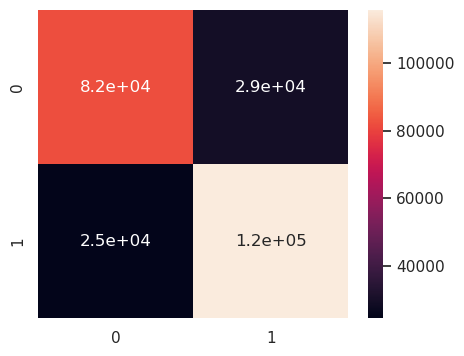

In [26]:
cm = confusion_matrix(y_test, y_pred)

plt.figure(figsize = (5, 4))
sns.set(font_scale=1)
sns.heatmap(cm, annot=True);

#### Variable importance and interpretation
The `xgb` package includes an own engine for variable importance and interpretation.
However, this tool is quite basic and the results are hard to interpret.


<Axes: title={'center': 'Feature importance'}, xlabel='F score', ylabel='Features'>

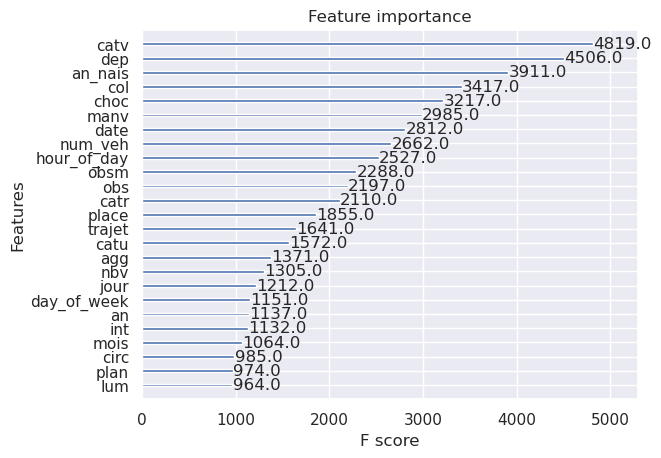

In [27]:
xgb.plot_importance(xgb_2, max_num_features=25);

In [28]:
# lets check the run time
if (cv_rerun == True):
    start_time = time.monotonic()
    
    thresholds = np.sort(xgb_2.feature_importances_)
    for thresh in thresholds:
     # select features using threshold
     selection = SelectFromModel(xgb_2, threshold=thresh, prefit=True)
     select_X_train = selection.transform(X_train)
     # train model
     selection_model = xgb.XGBClassifier()
     selection_model.fit(select_X_train, y_train)
     # eval model
     select_X_test = selection.transform(X_test)
     y_pred = selection_model.predict(select_X_test)
     predictions = [round(value) for value in y_pred]
     accuracy = accuracy_score(y_test, predictions)
     print("Thresh=%.3f, n=%d, Accuracy: %.2f%%" % (thresh, select_X_train.shape[1], accuracy*100.0))
    # Track the end of the modelling
    end_time = time.monotonic()
    print(timedelta(seconds=end_time - start_time))

In [35]:
# lets check the run time
cv_rerun = True

start_time = time.monotonic()
out_file_shap_values = './data/XGboost_model/231030_XGboost_model_gbtree_logloss_severe_shap_values.pkl'

if (cv_rerun == True):
    # compute the SHAP values for the linear model
    explainer = shap.Explainer(xgb_2)
    shap_values = explainer(X_train)
    
    # Dump the model for reuse
    with open(out_file_shap_values, 'wb') as f:
        pickle.dump(xgb_2, f)

else:
    with open(out_file_shap_values, 'rb') as f:
        shap_values = pickle.load(f)


# Track the end of the shap modelling
end_time = time.monotonic()
print(timedelta(seconds=end_time - start_time))

0:58:19.005670


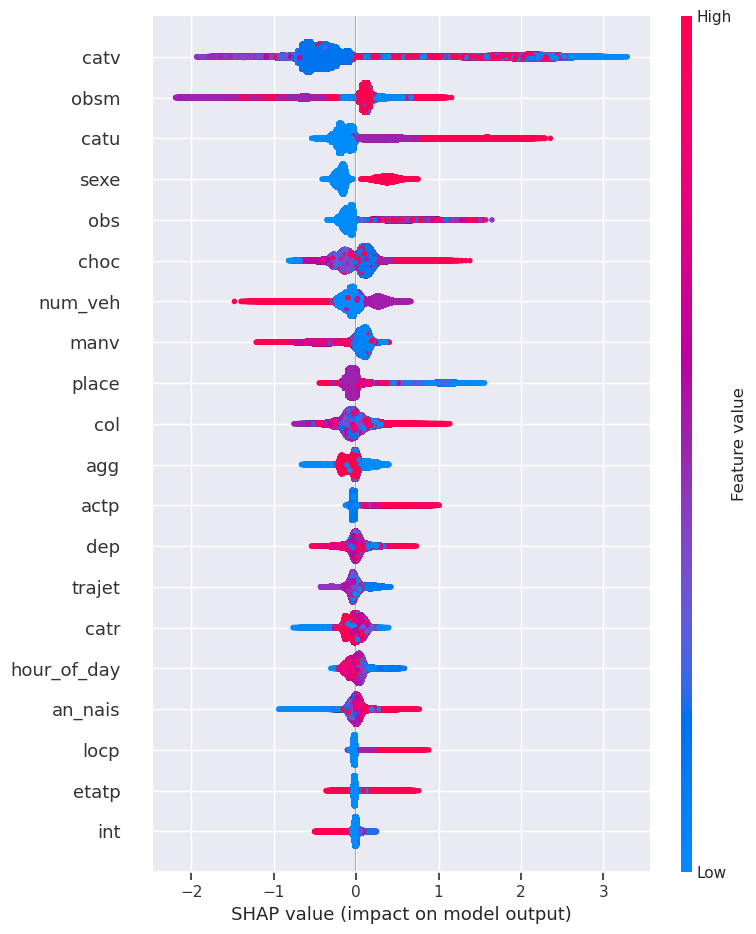

0:01:56.512417


In [41]:
#Summarize the effects of features
start_time = time.monotonic()

shap.summary_plot(shap_values, X_train)

end_time = time.monotonic()
print(timedelta(seconds=end_time - start_time))

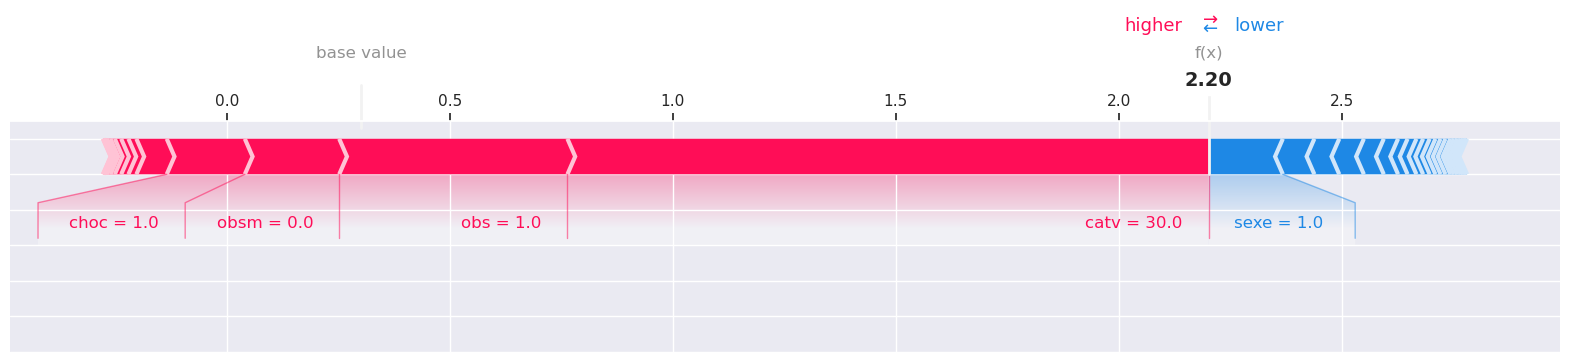

0:00:00.214736


In [40]:
start_time = time.monotonic()

#shap.force_plot(explainer.expected_value, shap_values[0], feature_names = explainer.feature_names)
shap.force_plot(explainer.expected_value, shap_values.values[0, :], X_train.iloc[0, :], matplotlib = True)

end_time = time.monotonic()
print(timedelta(seconds=end_time - start_time))

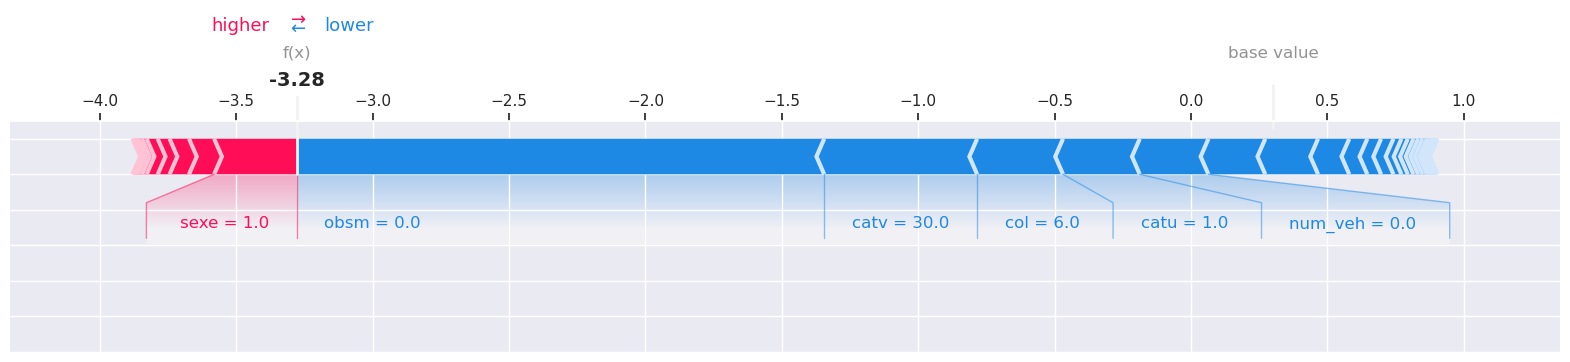

0:00:00.280595


In [39]:
start_time = time.monotonic()

#shap.force_plot(explainer.expected_value, shap_values[0], feature_names = explainer.feature_names)
shap.force_plot(explainer.expected_value, shap_values.values[1, :], X_train.iloc[0, :], matplotlib = True)

end_time = time.monotonic()
print(timedelta(seconds=end_time - start_time))

## References
[1] [Bergstra, J., Yamins, D., Cox, D. D. (2013) Making a Science of Model Search: Hyperparameter Optimization in Hundreds of Dimensions for Vision Architectures. TProc. of the 30th International Conference on Machine Learning (ICML 2013), June 2013, pp. I-115 to I-23.](https://proceedings.neurips.cc/paper_files/paper/2011/file/86e8f7ab32cfd12577bc2619bc635690-Paper.pdf)

[2] https://towardsdatascience.com/hyperopt-demystified-3e14006eb6fa

[3] https://xgboost.readthedocs.io/en/stable/tutorials/categorical.html

[4] https://github.com/hyperopt/hyperopt

[5] https://www.kaggle.com/code/prashant111/a-guide-on-xgboost-hyperparameters-tuning

[6] https://github.com/hyperopt/hyperopt/wiki/FMin

[7] https://xgboost.readthedocs.io/en/stable/tutorials/param_tuning.html

[8] https://www.datamachines.io/blog/auc-vs-log-loss

[9] [Rashmi, K.V., Gilad-Bachrach (2015) DART: Dropouts meet Multiple Additive Regression Trees. arXiv:1505.01866v](https://doi.org/10.48550/arXiv.1505.01866)

[10] https://datamachines.com/blog/auc-vs-log-loss

[11] https://stats.stackexchange.com/questions/322408/logloss-vs-gini-auc

[12] https://machinelearningmastery.com/feature-importance-and-feature-selection-with-xgboost-in-python/